# Raster GeoTiff (COG) to DGGS (IGEO7)

Required Python packages (e.g. Colab):

- requests
- pandas
- numpy
- shapely
- geopandas
- rasterio
- pyarrow
- tqdm
- dggrid4py

For a `micromamba` / `miniconda` enviroment we should install via conda/micromamba

In [1]:
# could do pip install if imports don't work
# dggrid4py always via pip (not on conda-forge)
# !pip install dggrid4py

In [ ]:
from pathlib import Path
import os
import io
import sys
import copy
import stat
import shutil
import math
import json

import requests
import numpy as np
import pandas as pd

import pyproj
from pyproj import CRS
import geopandas as gpd
from shapely.geometry import box, mapping, shape
from shapely.geometry import Point, Polygon
from shapely.ops import transform

import rasterio
from rasterio.windows import Window
from affine import Affine

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

from tqdm import tqdm

## Initialisation of tools and functions

- setup DGGRID executable
- load needed library functions for conversion

In [4]:
# we need the DGGRID executable
# For a `micromamba` / `miniconda` enviroment we can install via conda/micromamba (conda install -c conda-forge dggrid)
# if not in a conda environment, skip to next cell

dggrid_exec = 'dggrid'

# if installed with conda/micromamba or compiled locally, we can ask the system for the location
if not os.path.isfile(dggrid_exec) and not os.access(dggrid_exec, os.X_OK): 
    if shutil.which("dggrid83"):
        dggrid_exec = shutil.which("dggrid83")
    elif shutil.which("dggrid8"):
        dggrid_exec = shutil.which("dggrid8")
    elif shutil.which("dggrid"):
        dggrid_exec = shutil.which("dggrid")
    else:
        print("No dggrid executable found in path")

    if os.path.isfile(dggrid_exec) and os.access(dggrid_exec, os.X_OK):
        print(f"A DGGRID executable is available at: {dggrid_exec}")
    else:
        print("No usable dggrid executable found in path")
else:
    print(f"Executable already available: {dggrid_exec}")


A DGGRID executable is available at: /Users/akmoch/bin/dggrid83


In [5]:
dggrid_exec

'/Users/akmoch/bin/dggrid83'

In [ ]:
from dggrid4py import DGGRIDv7
from dggrid4py import igeo7
from dggrid4py import igeo7_ext

if not os.path.isfile(dggrid_exec) or not os.access(dggrid_exec, os.X_OK):
    raise ValueError(f"dggrid executable not found or not executable: {dggrid_exec}")

working_dir=os.curdir
capture_logs=True
silent=True
# if self-compiled or installed with conda, we can set performance options `tmp_geo_out_legacy=False`and `has_gdal=True`
tmp_geo_out_legacy=False
has_gdal=True
debug=False

dggrid_instance = DGGRIDv7(
    executable=dggrid_exec, working_dir=working_dir, capture_logs=capture_logs, silent=silent, tmp_geo_out_legacy=tmp_geo_out_legacy, has_gdal=has_gdal, debug=debug
)


In [ ]:
dggrid_get_res(dggrid_instance, "ISEA7H", 16)

,cells,average_hexagon_area_km2,cls_km,average_hexagon_area_m2,cls_m
isea7h_resolution,,,,,
0,12,5.100656e+07,8199.500370,5.100656e+13,8.199500e+06
1,72,7.286652e+06,3053.223243,7.286652e+12,3.053223e+06
2,492,1.040950e+06,1151.643010,1.040950e+12,1.151643e+06
3,3432,1.487072e+05,435.153149,1.487072e+11,4.351532e+05
4,24012,2.124388e+04,164.465580,2.124388e+10,1.644656e+05
5,168072,3.034840e+03,62.161776,3.034840e+09,6.216178e+04
6,1176492,4.335486e+02,23.494923,4.335486e+08,2.349492e+04
7,8235432,6.193552e+01,8.880245,6.193552e+07,8.880245e+03
8,57648012,8.847931e+00,3.356417,8.847931e+06,3.356417e+03


## Start of the workflow


### 1) initial calibration of batch-size

- set the `raster_path` to the COG GeoTiff file
- no need to change `mem_use_mb`, `window_blocks_per_chunk`, `pix_size_factor` or other parameters unless otherwise explicitely desired

In [ ]:
raster_path = os.path.expanduser("merit_dem_pori_cog.tif")

# !gdal_translate -f COG merit_dem_pori.tif merit_dem_pori_cog.tif

In [ ]:

mem_use_mb = 100
window_blocks_per_chunk = None
pix_size_factor=1   # oversampling factor to keep extra detail (between 1 same-ish to 3 very detailed/lots duplication)
dggrid_dggs_ref="ISEA7H" # ISEA7H and IGEO7 have same grid configuration, but for resolution testing DGGRID can only use ISEA7H, but for cell-ids in the workflow we want IGEO7/Z7 cell ids
dggs_type="IGEO7"
max_res=16
pixel_edge_len = -1
src_crs_ref = "EPSG:4326"
src_epsg = 4326

with rasterio.open(raster_path) as src:
    # Determine chunk size if not provided
    print("##############################################")
    print("############## calibrating initial conversion parameters to balance workload ##########")
    print("---- raster metadata ----")
    print(src.meta)
    print("---- raster crs ----")
    print(src.meta['crs'])
    src_crs_ref = src.meta['crs']
    src_epsg = src_crs_ref.to_epsg()
    print("---- raster blocks ----")
    if window_blocks_per_chunk is None:
        window_blocks_per_chunk = igeo7_ext.suggest_window_blocks_per_chunk(src, mem_use_mb)
    print("---- guess approx. pixel side length ----")
    pixel_edge_len = igeo7_ext.get_raster_pixel_edge_len(src, adjust_latitudes=True, pix_size_factor=2)
    print(pixel_edge_len)
    print("---- proposising dggs grid resolution ----")
    propose_dggs_info_dict = igeo7_ext.propose_dggs_level_for_pixel_length(dggrid_instance, pixel_edge_len, pix_size_factor=pix_size_factor, dggrid_dggs=dggrid_dggs_ref, max_res=max_res)
    dg_level = propose_dggs_info_dict['resolution']
    print(f"Proposed DGGS resolution: {dg_level}")

##############################################
############## calibrating initial conversion parameters to balance workload ##########
---- raster metadata ----
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 387, 'height': 376, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Estonian Coordinate System of 1997",GEOGCS["EST97",DATUM["Estonia_1997",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6180"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4180"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",57.5175539305556],PARAMETER["central_meridian",24],PARAMETER["standard_parallel_1",59.3333333333333],PARAMETER["standard_parallel_2",58],PARAMETER["false_easting",500000],PARAMETER["false_northing",6375000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3301"]]'), 'transform': Affin

In [95]:
# manual overwrite for testing, don't keep active
# dg_level = 10
# window_blocks_per_chunk=2

In [ ]:
# review batch sizes/place (raster data block windows)
bounds_list = []

for window, bounds, data, transform in igeo7_ext.extract_windows_with_bounds(raster_path, window_blocks_per_chunk=window_blocks_per_chunk, mem_use_mb=mem_use_mb):
    # bounds contains (minx, miny, maxx, maxy) in geographic coordinates
    # print(bounds)
    # print(data.shape)
    bbox = bbox = box(*bounds)
    bounds_list.append(bbox)

expected_window_steps = len(bounds_list)
print(bounds)
gpd.GeoDataFrame({'geometry': bounds_list}, crs=src_crs_ref).explore()

(647926.69061292, 6443283.235985573, 671494.1846109828, 6466180.852893252)


### Batch conversion of window blocks to separate DGGS Parquet

- make a data_folder into where we export all the separate parquet files for this one raster source file

In [14]:
main_output_folder = 'output'
parquet_subfolder = os.path.basename(raster_path).replace(".tiff", "").replace(".tif", "") + "_parquet_out"
target_folder = os.path.join(main_output_folder, parquet_subfolder)
param_parquet_compression = "snappy"
parquet_filename_template = 'data-{0}.parquet'.format

if not os.path.exists(target_folder):
    os.makedirs(target_folder, exist_ok=True)

In [15]:
print(f"Expecting {expected_window_steps} conversion steps/output parquet files in: {target_folder}")

Expecting 1 conversion steps/output parquet files in: output/merit_dem_pori_cog_parquet_out


In [ ]:
# describe the target data variable
var_desc = {
    'metadata' : 'Merit DEM over Porijõgi.',
    'var_name': 'elevation',  # no spaces or special characters
    'var_type': 'scalar',   # scalar or categorical
    'src_raster_origin': raster_path,
    'src_raster_crs': src_epsg,
    'dggs_type': dggs_type,
    'sampling_dggs_level': dg_level,
    'sampling_cls_m': propose_dggs_info_dict['cls_m'],
    'sampling_average_hexagon_area_m2': propose_dggs_info_dict['average_hexagon_area_m2'],
    'sampling_pixel_edge_len': pixel_edge_len,
    'param_window_blocks_per_chunk': window_blocks_per_chunk,
    'param_mem_use_mb': mem_use_mb,
    'param_pix_size_factor': pix_size_factor,
    'param_max_res': max_res,
    'param_parquet_compression': param_parquet_compression,
    'param_parquet_filename_template': parquet_filename_template('XXX')
}
print(f"Folowing metdata in {target_folder}/metadata.json")

with open(os.path.join(target_folder, "metadata.json"), 'w') as fh:
    json.dump(var_desc, fh)
    
print(var_desc)

Folowing metdata in output/merit_dem_pori_cog_parquet_out/metadata.json
{'metadata': 'Merit DEM over Porijõgi.', 'var_name': 'elevation', 'var_type': 'scalar', 'src_raster_origin': 'dem/merit_dem_pori_cog.tif', 'src_raster_crs': 3301, 'dggs_type': 'IGEO7', 'sampling_dggs_level': 13, 'sampling_cls_m': 25.88990020751953, 'sampling_average_hexagon_area_m2': 526.4000244140625, 'sampling_pixel_edge_len': 60.8979173079133, 'param_window_blocks_per_chunk': 2, 'param_mem_use_mb': 100, 'param_pix_size_factor': 1, 'param_max_res': 16, 'param_parquet_compression': 'snappy', 'param_parquet_filename_template': 'data-XXX.parquet'}


In [17]:
with open(os.path.join(target_folder, "metadata.json"), 'r') as fh:
    var_desc = json.load(fh)
    
print(var_desc)

{'metadata': 'Merit DEM over Porijõgi.', 'var_name': 'elevation', 'var_type': 'scalar', 'src_raster_origin': 'dem/merit_dem_pori_cog.tif', 'src_raster_crs': 3301, 'dggs_type': 'IGEO7', 'sampling_dggs_level': 13, 'sampling_cls_m': 25.88990020751953, 'sampling_average_hexagon_area_m2': 526.4000244140625, 'sampling_pixel_edge_len': 60.8979173079133, 'param_window_blocks_per_chunk': 2, 'param_mem_use_mb': 100, 'param_pix_size_factor': 1, 'param_max_res': 16, 'param_parquet_compression': 'snappy', 'param_parquet_filename_template': 'data-XXX.parquet'}


In [ ]:
%%time

for idx, (window, bounds, window_data, full_transform) in tqdm(enumerate(igeo7_ext.extract_windows_with_bounds(raster_path, window_blocks_per_chunk=window_blocks_per_chunk, mem_use_mb=mem_use_mb))):
    # bounds contains (minx, miny, maxx, maxy) in geographic coordinates
    # data contains the numpy array for this window
    # restore the local transform for this window
    window_transform = rasterio.windows.transform(window, full_transform)
    print(f"Window transform: {window_transform}")
    
    # Make a bbox from the bounds of this window
    print(f"Window bounds (left, bottom, right, top): {bounds}")
    bbox = box(*bounds)
    if src_epsg != 4326:
        bbox = gpd.GeoSeries([bbox], crs=src_crs_ref).to_crs(4326).loc[0]
        print(bbox)

    geodf_points_in_crs = igeo7_ext.create_geopoints_for_window(full_transform, window, window_data, crs_ref=src_crs_ref)
    # gdf_coded_centroids = dggrid_instance.cells_for_geo_points(geodf_points_wgs84=geodf_points_wgs84, cell_ids_only=True, dggs_type='IGEO7', resolution=dg_level, output_address_type='Z7_STRING')
    geodf_points_in_crs.sindex
    
    # if we oversample at (much) higher resolution as the source data, we don't need polygons
    # gdf_grid = dggrid_instance.grid_cell_polygons_for_extent('IGEO7', dg_level, clip_geom=bbox, output_address_type='Z7_STRING')
    gdf_hexpoints = dggrid_instance.grid_cell_centroids_for_extent('IGEO7', dg_level, clip_geom=bbox, output_address_type='Z7_STRING')
    gdf_hexpoints.crs = 4326
    if src_epsg != 4326:
        gdf_hexpoints = gdf_hexpoints.to_crs(src_crs_ref)
    gdf_hexpoints.sindex

    joined_hexpoints = gpd.sjoin_nearest(gdf_hexpoints[['name', 'geometry']], geodf_points_in_crs[['data', 'geometry']], how='left', distance_col='distance')
    df = joined_hexpoints[['name','data']].rename(columns={'name':'cellids', 'data': var_desc['var_name']}).set_index('cellids', drop=True).dropna()
    if df.index.size > 0:
        # Convert DataFrame to PyArrow Table
        table = pa.Table.from_pandas(df)
        pq.write_table(
            table,
            os.path.join(target_folder, parquet_filename_template(idx)),
            compression=param_parquet_compression
        )

0it [00:00, ?it/s]

Window transform: | 60.90, 0.00, 647896.24|
| 0.00,-60.90, 6466211.30|
| 0.00, 0.00, 1.00|
Window bounds (left, bottom, right, top): (647926.69061292, 6443283.235985573, 671494.1846109828, 6466180.852893252)
POLYGON ((26.90900157695047 58.09722879689946, 26.92593325676691 58.3026202070554, 26.524248180670842 58.31121436132922, 26.509636256752046 58.10577326868631, 26.90900157695047 58.09722879689946))


1it [00:49, 49.45s/it]

CPU times: user 38.4 s, sys: 725 ms, total: 39.2 s
Wall time: 49.5 s


In [94]:
df = pd.read_parquet('output/merit_dem_pori_cog_parquet_out/data-0.parquet')
df.sample()

,elevation
cellids,
000102612204205,110.900002


In [95]:
print(df.index.size)

1021617


In [ ]:
res = igeo7.get_z7string_resolution(df.index[0])
dggrid_res = igeo7_ext.dggrid_get_res(dggrid_instance, "ISEA7H", res)
cls_m = dggrid_res.loc[res, 'cls_m']
cls_m, res

(25.8899, 13)

In [78]:
%%time

gdf = dggrid_igeo7_grid_cell_polygons_from_cellids(df.index, dggrid_instance)
gdf.head(3)

CPU times: user 46 s, sys: 1.46 s, total: 47.5 s
Wall time: 56.5 s


,name,geometry
0,000102243522325,"POLYGON ((26.90946 58.10398, 26.90934 58.10387..."
1,000102243522363,"POLYGON ((26.90915 58.10413, 26.90903 58.10402..."
2,000102243522306,"POLYGON ((26.90949 58.10423, 26.90937 58.10411..."


In [79]:
gdf = gdf.set_index('name', drop = True).join(df)

In [80]:
from lonboard import viz, PolygonLayer, ScatterplotLayer, Map
from lonboard.colormap import apply_continuous_cmap

In [81]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl

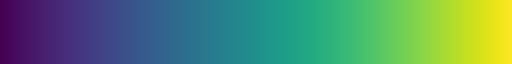

In [82]:
colormaps['viridis']

In [83]:
min_bound = -10
max_bound = 350
elevation = gdf["elevation"]
normalized_elevation = (elevation - min_bound) / (max_bound - min_bound)

In [45]:
layer = PolygonLayer.from_geopandas(gdf)
# layer = ScatterplotLayer.from_geopandas(gdf)

layer.get_fill_color = apply_continuous_cmap(
    normalized_elevation, colormaps['viridis'], alpha=0.7
)

layer.get_radius = cls_m / 2
layer.radius_units = "meters"
layer.radius_min_pixels = 0.5


m = Map(layer, _height=800)

In [ ]:
m

In [47]:
del(m)
del(layer)

In [105]:
gdf.index.size

1021617

In [288]:
gdf.sample(3)

,geometry,elevation,par_12,par_11,par_10,par_9,par_8,par_7,Q2DI,Q,I,J,slope
name,,,,,,,,,,,,,
000102612546246,"POLYGON ((26.56750 58.27931, 26.56738 58.27919...",67.300003,00010261254624,0001026125462,000102612546,00010261254,0001026125,000102612,4 95582 803732,4,95582,803732,0.000000
000102245334310,"POLYGON ((26.83924 58.19661, 26.83912 58.19650...",79.500000,00010224533431,0001022453343,000102245334,00010224533,0001022453,000102245,4 96789 802557,4,96789,802557,0.000000
000102244164602,"POLYGON ((26.70418 58.19463, 26.70405 58.19452...",98.599998,00010224416460,0001022441646,000102244164,00010224416,0001022441,000102244,4 95870 802610,4,95870,802610,0.737666


In [ ]:
igeo7_ext.to_parent_series(pd.Series(gdf.head(3).index))

array(['00010224352232', '00010224352236', '00010224352230'], dtype=object)

In [ ]:
res_up = res - 1
parent_name = f"par_{res_up}"

gdf[parent_name] = igeo7_ext.to_parent_series(pd.Series(gdf.index))

In [102]:
gdf.sample(3)

,geometry,elevation,par_12
name,,,
000102244553253,"POLYGON ((26.70440 58.22998, 26.70428 58.22987...",90.700005,00010224455325
000102246065641,"POLYGON ((26.65244 58.10943, 26.65232 58.10932...",157.300003,00010224606564
000102246562621,"POLYGON ((26.66653 58.12888, 26.66640 58.12877...",148.300003,00010224656262


In [ ]:
current_res = res - 1

for i in range(0,res):
    res_up = current_res - 1
    current_label = f"par_{current_res}"
    parent_name = f"par_{res_up}"
    gdf[parent_name] = igeo7_ext.to_parent_series(gdf[current_label])
    current_res = current_res - 1

In [113]:
gdf.columns

Index(['geometry', 'elevation', 'par_12', 'par_11', 'par_10', 'par_9', 'par_8',
       'par_7'],
      dtype='object')

In [114]:
len(gdf['par_9'].unique())

477

In [115]:
gdf.sample(3)

,geometry,elevation,par_12,par_11,par_10,par_9,par_8,par_7
name,,,,,,,,
000102631225143,"POLYGON ((26.54611 58.12512, 26.54599 58.12501...",131.400009,00010263122514,0001026312251,000102631225,00010263122,0001026312,000102631
000102631160032,"POLYGON ((26.59449 58.15755, 26.59437 58.15743...",152.699997,00010263116003,0001026311600,000102631160,00010263116,0001026311,000102631
000102022235514,"POLYGON ((26.91245 58.23081, 26.91232 58.23069...",79.500000,00010202223551,0001020222355,000102022235,00010202223,0001020222,000102022


In [203]:
test_cell =  "000102633443605"

res = igeo7.get_z7string_resolution(test_cell)
parent, local_pos, is_center = igeo7.get_z7string_local_pos(test_cell)

print(res, parent, local_pos, is_center)

13 00010263344360 5 False


In [ ]:
try_res = igeo7.get_z7string_resolution(test_cell)
dggrid_res = igeo7_extdggrid_get_res(dggrid_instance, "ISEA7H", try_res)
try_cls_m = dggrid_res.loc[try_res, 'cls_m']
try_res, try_cls_m

(10, 479.4882)

In [ ]:
    df_flat['res_14'] = df_flat['cellid']
     
    flat_results = [df_flat[['cellid', 'resolution', 'landuse_class']]]
     
    for res in tqdm.tqdm(range(14, 7, -1)):
        
        res_col = f'res_{res}'
        parent_col = f'res_{res - 1}'
     
        if parent_col not in df_flat.columns:
            df_flat[parent_col] = to_parent_series(df_flat[res_col])
    
        print(f"res {res} - start agg")
        grouped = df_flat.groupby(parent_col)['landuse_class'].agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ).reset_index()
    
        print(f"res {res} - agged")
        grouped.columns = ['cellid', 'landuse_class']
        grouped['resolution'] = res - 1
        df_flat[parent_col] = df_flat[parent_col]  # retain for later
        flat_results.append(grouped)

    df_flat_all = pd.concat(flat_results, ignore_index=True)
    df_flat_all.rename(columns={'landuse_class': 'landuse_class_flat'}, inplace=True)

    df_hier = df_raw.copy()
    df_hier['parent_13'] = to_parent_series(pd.Series(df_hier['cellid']))
    
    hierarchical_results = [df_hier[['cellid', 'resolution', 'landuse_class']].rename(columns={'landuse_class': 'landuse_class_hierarchical'})]

    for res in tqdm.tqdm(range(13, 7, -1)):
        prev_df = hierarchical_results[-1]
        parent_col = f'parent_{res}'
     
        if parent_col not in prev_df.columns:
            prev_df[parent_col] = to_parent_series(pd.Series(df_hier['cellid']) if res == 13 else pd.Series(prev_df['cellid']))
    
        print(f"res {res} - start agg")
        grouped = prev_df.groupby(prev_df[parent_col])['landuse_class_hierarchical'].agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ).reset_index()
        
        print(f"res {res} - agged")
        grouped.columns = ['cellid', 'landuse_class_hierarchical']
        grouped['resolution'] = res
    
        # is that even needed?
        if res > 8:
            df_hier[f'parent_{res - 1}'] = to_parent_series(df_hier[parent_col])
       
        hierarchical_results.append(grouped)
     
    df_hier_all = pd.concat(hierarchical_results, ignore_index=True)

    # ---------- Merge Results ----------
    # Merge both by resolution + cellid
    final_df = pd.merge(
        df_flat_all,
        df_hier_all,
        on=['cellid', 'resolution'],
        how='outer'
    ).sort_values(['resolution', 'cellid'])
     
    # Preview
    print(final_df.head(3))

    out_fn = tile_fn.replace(".parquet", "_final_df.parquet")

    final_df.to_parquet(os.path.join(folder, out_fn), compression='snappy')
    